# Sentiment Analysis on Kiva Loans Dataset

### Inspect and Set up environment

In [5]:
import datetime
import pandas as pd
import numpy as np

In [6]:
print(datetime.datetime.now())

2021-04-26 02:41:58.995958


In [7]:
!which python

/usr/local/bin/python


In [8]:
!python --version

Python 3.7.10


In [9]:
!echo $PYTHONPATH

/env/python


In [43]:
!pip install unidecode
import re
import unidecode
import nltk
import spacy
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Sentiment Analysis via Shallow ML

In [11]:
# Get labeled training data

df = pd.read_csv("https://drive.google.com/uc?export=download&id=1b8MAiN-xBdk6scM-DnufkuijDZivZJqM")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


In [12]:
df = df.drop_duplicates(subset='Sentence')  # drop duplicates from the dataset; most efficient way to remove duplicates than do it separately on training and validation sets 
df.shape

(2382, 2)

In [13]:
# Split data into training and validation sets

from sklearn.model_selection import train_test_split

X = df['Sentence']
y = df['Polarity']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Preprocessing and FE Pipeline

Clean and preprocess the data, extract features from the text

In [14]:
print(X_train.shape)
print(X_val.shape)
y_train.value_counts()

(1786,)
(596,)


0    911
1    875
Name: Polarity, dtype: int64

In [26]:
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = nlp.Defaults.stop_words

# Remove "not" from stop words

spacy_stopwords -= {"not"}
stop_words = spacy_stopwords

In [16]:
lemmer = WordNetLemmatizer()

cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "i would",
  "i'd've": "i would have",
  "i'll": "i will",
  "i'll've": "i will have",
  "i'm": "i am",
  "i've": "i have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [27]:
def my_preprocess(doc):
    
    doc = doc.replace(u'’', u"'")
    doc = doc.replace(u'“', u'"')
    doc = doc.replace(u'”', u'"')
    
    # Lowercase
    doc = doc.lower()
    
    # Remove any "weird" characters
    doc = unidecode.unidecode(doc)
    doc = re.sub(r'[^\w\s]', '', doc)

    doc = expandContractions(doc)
    
    doc = ' '.join([w for w in doc.split() if w not in stop_words])
    
    doc = ' '.join([lemmer.lemmatize(w) for w in doc.split()])

    return doc

In [70]:
# Sentiment Analysis

sia = SentimentIntensityAnalyzer()

def siafn(corpus):

    count_pos=[]
    count_neu=[]
    count_neg=[]
    count_comp=[]
    for doc in corpus:
        pos_count=0
        neu_count=0
        neg_count=0
        comp_count=0
        score = sia.polarity_scores(doc)
        pos_count=score["pos"]
        neu_count=score["neu"]
        neg_count=score["neg"]
        comp_count=score["compound"]

        count_pos.append(score["pos"]) 
        count_neu.append(score["neu"])
        count_neg.append(score["neg"])
        count_comp.append(score["compound"])

    sia_score = pd.DataFrame([count_pos, count_neu, count_neg, count_comp])

    temp = pd.DataFrame.transpose(sia_score)
    print(temp.info)
    return np.array(temp)

In [83]:
# Create BOW features

vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                             max_features = 1000, 
                             stop_words=stop_words, use_idf=True, ngram_range=[1,2])
rf = RandomForestClassifier(criterion='entropy', random_state=223)

feature_processing =  FeatureUnion([ 
    ('bow', Pipeline([('vectorizer', vectorizer), ])),
    ('siafn', FunctionTransformer(siafn, validate=False))])

pipe = Pipeline([('features', feature_processing), ('clf', rf)])

### Model Training/Tuning/Cross Validation

Train a shallow ML classification model with hyperparameter tuning and cross validation

In [84]:
param_grid = {
    'features__bow__vectorizer__max_features': [500, 1000],
    'features__bow__vectorizer__use_idf': [True, False],
    'clf__n_estimators': [250, 500],
}

search = GridSearchCV(pipe, 
                      param_grid, 
                      cv=5, 
                      n_jobs=5, 
                      scoring='f1_macro', 
                      return_train_score=True, 
                      verbose=2)

search = search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed:  1.2min finished
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 'nt', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


<bound method DataFrame.info of           0      1      2       3
0     0.455  0.545  0.000  0.6124
1     0.533  0.467  0.000  0.6908
2     0.000  0.798  0.202 -0.4201
3     0.000  1.000  0.000  0.0000
4     0.000  0.699  0.301 -0.6486
...     ...    ...    ...     ...
1781  0.744  0.256  0.000  0.4404
1782  0.818  0.182  0.000  0.5423
1783  0.000  1.000  0.000  0.0000
1784  0.000  1.000  0.000  0.0000
1785  0.424  0.576  0.000  0.7964

[1786 rows x 4 columns]>


In [85]:
print("Best parameter (CV score: %0.5f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score: 0.84033):
{'clf__n_estimators': 500, 'features__bow__vectorizer__max_features': 1000, 'features__bow__vectorizer__use_idf': True}


In [74]:
# Print out the results of hyperparmater tuning

def cv_results_to_df(cv_results):
    results = pd.DataFrame(list(cv_results['params']))
    results['mean_fit_time'] = cv_results['mean_fit_time']
    results['mean_score_time'] = cv_results['mean_score_time']
    results['mean_train_score'] = cv_results['mean_train_score']
    results['std_train_score'] = cv_results['std_train_score']
    results['mean_test_score'] = cv_results['mean_test_score']
    results['std_test_score'] = cv_results['std_test_score']
    results['rank_test_score'] = cv_results['rank_test_score']

    results = results.sort_values(['mean_test_score'], ascending=False)
    return results

results = cv_results_to_df(search.cv_results_)
results

,clf__n_estimators,features__bow__vectorizer__max_features,features__bow__vectorizer__use_idf,mean_fit_time,mean_score_time,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score
6,500,1000,True,9.062586,0.585738,0.994538,0.000928,0.840329,0.011496,1
7,500,1000,False,8.885791,0.541815,0.994538,0.000928,0.838065,0.009467,2
2,250,1000,True,5.170820,0.461873,0.994539,0.000928,0.833524,0.011223,3
1,250,500,False,4.997179,0.447943,0.987252,0.001122,0.830195,0.011024,4
5,500,500,False,8.477953,0.602174,0.987252,0.001122,0.829619,0.011043,5
3,250,1000,False,5.121774,0.463652,0.994539,0.000928,0.829538,0.016260,6
0,250,500,True,4.602500,0.433082,0.987252,0.001122,0.827945,0.011645,7
4,500,500,True,8.486880,0.630648,0.987252,0.001122,0.827416,0.012421,8


In [75]:
y_val_pred = search.predict(X_val)

<bound method DataFrame.info of          0      1      2       3
0    0.000  0.645  0.355 -0.2960
1    0.000  0.703  0.297 -0.2755
2    0.000  0.864  0.136 -0.2960
3    0.174  0.826  0.000  0.6369
4    0.141  0.859  0.000  0.2023
..     ...    ...    ...     ...
591  0.266  0.734  0.000  0.7592
592  0.000  1.000  0.000  0.0000
593  0.262  0.738  0.000  0.4939
594  0.366  0.634  0.000  0.8439
595  0.000  0.328  0.672 -0.6249

[596 rows x 4 columns]>


In [76]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_true = y_val, y_pred = y_val_pred))

class_names = [str(x) for x in search.best_estimator_.classes_]
print(classification_report(y_true = y_val, y_pred = y_val_pred, target_names=class_names))

[[266  29]
 [ 47 254]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       295
           1       0.90      0.84      0.87       301

    accuracy                           0.87       596
   macro avg       0.87      0.87      0.87       596
weighted avg       0.87      0.87      0.87       596



### Model Assessment 

Use model to predict the sentiment of the testing dataset

In [77]:
# Get unseen test data

test_df = pd.read_csv("https://drive.google.com/uc?export=download&id=1taoTluPBUMt9JkKAnlqDTrU49DJFpJGW")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  600 non-null    object
 1   Polarity  600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB


In [78]:
y_test_pred = search.predict(test_df['Sentence'])

print(confusion_matrix(test_df['Polarity'], y_test_pred))
print(classification_report(test_df['Polarity'], y_test_pred))

<bound method DataFrame.info of          0      1      2       3
0    0.500  0.500  0.000  0.8402
1    0.222  0.778  0.000  0.6467
2    0.421  0.579  0.000  0.9079
3    0.000  1.000  0.000  0.0000
4    0.427  0.573  0.000  0.7717
..     ...    ...    ...     ...
595  0.000  0.807  0.193 -0.3382
596  0.135  0.481  0.385 -0.6369
597  0.000  0.658  0.342 -0.3818
598  0.000  0.197  0.803 -0.6230
599  0.240  0.489  0.271 -0.1779

[600 rows x 4 columns]>
[[258  29]
 [ 79 234]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       287
           1       0.89      0.75      0.81       313

    accuracy                           0.82       600
   macro avg       0.83      0.82      0.82       600
weighted avg       0.83      0.82      0.82       600



### Show five test instances the model predicted incorrectly. Deep dive to find out why they were wrong.

In [46]:
eval_df = pd.concat([test_df, pd.DataFrame(data=y_test_pred, columns=['Pred'])], axis=1)

In [47]:
eval_df2 = eval_df[eval_df['Polarity']!= eval_df['Pred']]
eval_df3 = eval_df2.iloc[:5, :]
eval_df3

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,Sentence,Polarity,Pred
3,It's a feel-good film and that's how I felt wh...,1,0
7,I couldn't take them seriously.,0,1
12,Not too screamy not to masculine but just righ...,1,0
36,"The soundtrack wasn't terrible, either.",1,0
43,The last 15 minutes of movie are also not bad ...,1,0


In [48]:
print(np.asarray(eval_df3['Sentence'].tolist()))

["It's a feel-good film and that's how I felt when I came out of the cinema!  "
 "I couldn't take them seriously.  "
 'Not too screamy not to masculine but just right.  '
 "The soundtrack wasn't terrible, either.  "
 'The last 15 minutes of movie are also not bad as well.  ']


In [49]:
eval_df2['len'] = eval_df2.iloc[:,0].apply(lambda x: len(x.split()))
eval_df2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Sentence,Polarity,Pred,len
3,It's a feel-good film and that's how I felt wh...,1,0,16
7,I couldn't take them seriously.,0,1,5
12,Not too screamy not to masculine but just righ...,1,0,9
36,"The soundtrack wasn't terrible, either.",1,0,5
43,The last 15 minutes of movie are also not bad ...,1,0,12


Mean document length for incorrect prediction: 15.68
Median document length for incorrect prediction: 14.00


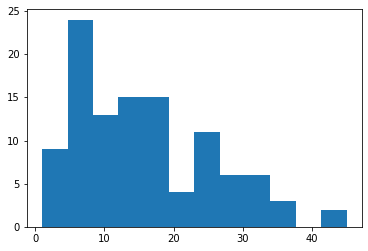

In [50]:
print(f"Mean document length for incorrect prediction: {eval_df2['len'].mean():.2f}")
print(f"Median document length for incorrect prediction: {eval_df2['len'].median():.2f}")

import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(eval_df2['len'], bins=12);

Mean document length for correct prediction: 14.94
Median document length for correct prediction: 12.00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


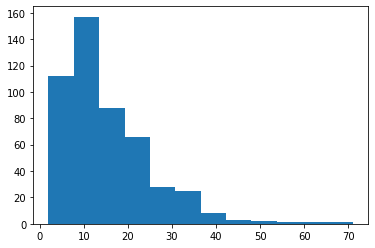

In [51]:
eval_df4 = eval_df[eval_df['Polarity']== eval_df['Pred']]
eval_df4['len'] = eval_df4.iloc[:,0].apply(lambda x: len(x.split()))
print(f"Mean document length for correct prediction: {eval_df4['len'].mean():.2f}")
print(f"Median document length for correct prediction: {eval_df4['len'].median():.2f}")
plt.hist(eval_df4['len'], bins=12);

The average document length of incorrect predictions tends to be 0.7 word longer than the correct predictions (15.7 vs. 15). The median document length of incorrect predictions is as much as 2 words longer versus the correct predictions of 12 words. It shows that the sentence structure of incorrect predictions may be more complex containing mixed sentiments than the correct predictions. This could also indicate that the shorter sentences are easier for the model to learn, whereas it’s more difficult to learn longer sentences.  

A readthrough of the incorrectly predicted sentences shows that they tend to include more than 1 expression of sentiment, and are usually composed of parts connected by words which signal sentiment changes or twists, when the message's meaning didn't change or was ambiguous also to humans. Some of these sentences seem to be sarcastic, and how that exact same sentence is said with what intonation could be the only determinant of the sentiment of that sentence. 

### Sentiment Analysis via Deep Learning (Transformer)

Build a model on the same dataset and compare the results to the Shallow ML model

In [1]:
!pip install simpletransformers

     |████████████████████████████████| 215kB 14.9MB/s 
     |████████████████████████████████| 81kB 10.4MB/s 
     |████████████████████████████████| 2.1MB 49.6MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 3.3MB 56.1MB/s 
     |████████████████████████████████| 122kB 55.6MB/s 
     |████████████████████████████████| 2.1MB 52.5MB/s 
     |████████████████████████████████| 204kB 58.3MB/s 
     |████████████████████████████████| 1.2MB 47.2MB/s 
     |████████████████████████████████| 8.2MB 51.3MB/s 
     |████████████████████████████████| 102kB 14.4MB/s 
     |████████████████████████████████| 133kB 40.5MB/s 
     |████████████████████████████████| 163kB 59.2MB/s 
     |████████████████████████████████| 901kB 51.1MB/s 
     |████████████████████████████████| 245kB 58.4MB/s 
     |████████████████████████████████| 112kB 49.0MB/s 
     |████████████████████████████████| 4.2MB 40.7MB/s 
     |████████████████████████████████| 81kB 10.3MB

In [3]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [4]:
from sklearn.metrics import f1_score
f1=f1_score

# Model configuration

model_args = ClassificationArgs()

model_args.manual_seed = 4
model_args.num_train_epochs = 2
model_args.do_lower_case = True
model_args.learning_rate = 2e-5
model_args.weight_decay = 1e-8
model_args.use_early_stopping = True
model_args.early_stopping_delta = 0.01
model_args.early_stopping_metric = 'f1'
model_args.early_stopping_metric_minimize = False
model_args.early_stopping_patience = 5
model_args.evaluate_during_training_steps = 1000

# Create a ClassificationModel

model = ClassificationModel("roberta", "roberta-base", args=model_args, use_cuda=True)

INFO:filelock:Lock 139738826665680 acquired on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

INFO:filelock:Lock 139738826665680 released on /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b.lock
INFO:filelock:Lock 139741183257168 acquired on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock


Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

INFO:filelock:Lock 139741183257168 released on /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7.lock
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of R

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

INFO:filelock:Lock 139738826709456 released on /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab.lock
INFO:filelock:Lock 139738688131984 acquired on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock


Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

INFO:filelock:Lock 139738688131984 released on /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b.lock
INFO:filelock:Lock 139738687711760 acquired on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock


Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

INFO:filelock:Lock 139738687711760 released on /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730.lock


In [ ]:
df.columns=["Sentence","Polarity"]

X_train, X_val = train_test_split(df, test_size=0.2, random_state=123)

In [ ]:
# Train the model

model.train_model(X_train, f1=f1_score, output_dir= "outputs/7th_model")

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:449: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1920 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_2_2


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/240 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/240 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/7th_model.


(1440, 0.14715685586493743)

In [ ]:
# Model performance on validation set

result, model_outputs, wrong_predictions = model.eval_model(X_val, f1=f1_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1029: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/480 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_2_2


Running Evaluation:   0%|          | 0/60 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model:{'mcc': 0.9459091109592532, 'tp': 234, 'tn': 233, 'fp': 8, 'fn': 5, 'auroc': 0.9886890397402732, 'auprc': 0.9895447186454256, 'f1': 0.972972972972973, 'eval_loss': 0.20599439061552402}


In [ ]:
result

{'auprc': 0.9895447186454256,
 'auroc': 0.9886890397402732,
 'eval_loss': 0.20599439061552402,
 'f1': 0.972972972972973,
 'fn': 5,
 'fp': 8,
 'mcc': 0.9459091109592532,
 'tn': 233,
 'tp': 234}

In [ ]:
model_outputs[1:20,]

array([[ 4.66796875, -4.22265625],
       [ 4.63671875, -4.22265625],
       [-1.86621094,  2.05078125],
       [ 4.76171875, -4.234375  ],
       [-4.37890625,  4.40234375],
       [-4.52734375,  4.52734375],
       [ 4.65625   , -4.1640625 ],
       [ 4.68359375, -4.30078125],
       [ 4.671875  , -4.23828125],
       [ 4.48828125, -4.16796875],
       [-4.5       ,  4.48828125],
       [ 4.6875    , -4.2890625 ],
       [-4.51953125,  4.52734375],
       [ 4.75390625, -4.3046875 ],
       [-4.5       ,  4.53515625],
       [ 4.6328125 , -4.25390625],
       [ 4.75390625, -4.28515625],
       [-4.52734375,  4.53515625],
       [ 4.71484375, -4.33203125]])

In [ ]:
# Model prediction on test set

predictions, raw_outputs = model.predict(list(test_df['Sentence']))
print(predictions[0])
print(raw_outputs[0])

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

1
[-4.51171875  4.5546875 ]


In [ ]:
# Model performance on test dataset; best model
# Have also tried using 1 LSTM layer with 1 Dense layer with 57k parameters, but the F1 macro on test set was 0.80 and worse than the RoBERTa transformer

from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(test_df['Polarity'], predictions))
print(confusion_matrix(test_df['Polarity'], predictions))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       287
           1       0.95      0.98      0.96       313

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600

[[271  16]
 [  7 306]]


The conclusion is the results from the RoBERTa transformer is significantly better than the results from shallow ML model.  The shallow ML model took a substantial amount of time to tweak hyperparameters, trying different models and feature extractions, and was a highly manual process.  RoBERTa transformer reached 0.96 macro F1 with little false postives and false negatives in the confusion matrix on the test dataset, and it reached this positive outcomes within relatively shorter development and training time.  The transformer had significantly outperformed shallow ML in this case.